In [1]:
import requests
import pandas as pd
import numpy as np
import json
import re
from bs4 import BeautifulSoup
import zipfile
import os
from datetime import datetime
from functools import reduce

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import shap
import openpyxl
import xlrd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% ! important; }<style>"))
pd.reset_option('display.max_colwidth')
import warnings
warnings.simplefilter("ignore")

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 14)
    plt.yticks(tick_marks, classes, fontsize = 14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=25)

    plt.tight_layout()
    plt.ylabel('Реальное значение целевой переменной', fontsize = 16)
    plt.xlabel('Предсказанное значение целевой переменной', fontsize = 16)

In [3]:
    
# функция для извлечения даты из строки и преобразования её в datetime
def parse_and_format_date(string):
    match = re.search(r'(\d{1,2})\s([а-яА-я]+)\s(\d{4})\sг.', string)
    if match:
        day = int(match.group(1))
        month = months[match.group(2)]
        year = int(match.group(3))
        date = datetime(year, month, day)
        return str(pd.to_datetime(date).date())
    
    
# функция для создания маски по дате  
def check_date(x):
    try:
        pd.to_datetime(x, format='%Y-%m-%d')
        return True
    except ValueError:
        return False
    
def extract_number(text):
    try:
        license_number = re.search('лицензия НОМЕР (.*?),', text).group(1)
        if license_number.isdigit():
            return license_number
        else:
            return None
    except AttributeError:
        return None

In [4]:
# создаём словарь для преобразования названий месяцев в их числовой эквивалент
months = {
    'Января': 1,
    'Февраля': 2,
    'Марта': 3,
    'Апреля': 4,
    'Мая': 5,
    'Июня': 6,
    'Июля': 7,
    'Августа': 8,
    'Сентября': 9,
    'Октября': 10,
    'Ноября': 11,
    'Декабря': 12
}

In [5]:
# Создаем пустой словарь для хранения датафремов c данными после парсинга
dataframes = {}

for filename in os.listdir('data_rating'):
    if filename.endswith('.csv'):
        dataframes[filename[:-4]] = pd.read_csv('data_rating/' + filename, header=None, names=['rating'])
        print(f'Рейтинг: {filename[:-4]}')

Рейтинг: AKM_rus
Рейтинг: exra_rus
Рейтинг: fitch_long
Рейтинг: fitch_rus
Рейтинг: moody_long
Рейтинг: moody_rus
Рейтинг: NRA_rus
Рейтинг: rusrate
Рейтинг: rusrate_rus
Рейтинг: sp_long
Рейтинг: sp_rus
Рейтинг: sp_short


### Начнем обработку данных

In [6]:
all_banks_list = []

for dataset in dataframes:
    for row in range(dataframes[dataset].shape[0]):
        if dataframes[dataset].loc[row].str.startswith('Сортировка').any():
            dataframes[dataset].loc[row] = dataframes[dataset].loc[row].apply(parse_and_format_date)
     
    dates_mask = dataframes[dataset]['rating'].apply(check_date)
    dataframes[dataset]['date'] = pd.NA
    dataframes[dataset].loc[dates_mask, 'date'] = dataframes[dataset].loc[dates_mask, 'rating']
    dataframes[dataset]['date'].fillna(method='ffill', inplace=True)
    dataframes[dataset] = dataframes[dataset].loc[~dates_mask] # извлекли даты и записали отдельно
    
    dataframes[dataset][['rating', 'company']] = dataframes[dataset]['rating'].str.split('\) ', n=1, expand=True)
    dataframes[dataset]['rating'] = dataframes[dataset]['rating'] + ')' # извлекли названия компаний и записали отдельно
    dataframes[dataset]['rating'] = dataframes[dataset]['rating'].str.strip()
    
    all_banks_list.append(dataframes[dataset]['company'].fillna('None'))

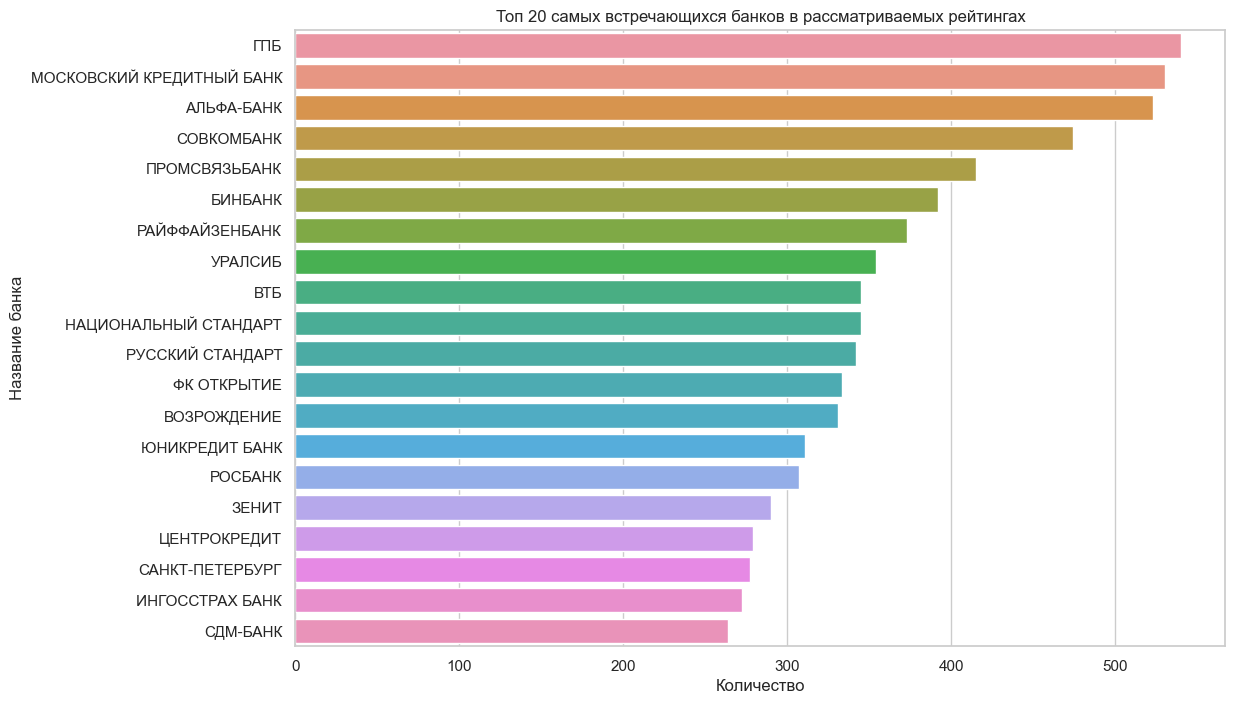

In [7]:
all_banks_array = np.concatenate(all_banks_list)

bank_series = pd.Series(all_banks_array)

# Получаем top 20 банков
top_20_banks = bank_series.value_counts().nlargest(20).index

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
ax = sns.countplot(y=bank_series, order=top_20_banks)

# Устанавливаем заголовок и подписи осей
ax.set_title("Топ 20 самых встречающихся банков в рассматриваемых рейтингах")
ax.set_xlabel("Количество")
ax.set_ylabel("Название банка")

plt.show()

### Добавим номера лицензий для дальнейшего объединения датасетов

In [8]:
all_banks_array = np.concatenate(all_banks_list)
all_banks_array = np.unique(all_banks_array)

all_banks_list_unique = all_banks_array.tolist()

# Преобразуем все названия банков в нижний регистр
all_banks_list_unique = [bank.lower() for bank in all_banks_list_unique]
all_banks_list_unique = [bank for bank in all_banks_list_unique if bank != 'none']
len(all_banks_list_unique) # кол-во уникальных банко в нашем датасете

472

In [9]:
df_vocab = pd.read_csv('./unique_banks.csv', header=None, names=['name'], skiprows=1, encoding='utf-8', sep='\t')

df_vocab['number'] = df_vocab['name'].apply(extract_number)
df_vocab['name'] = df_vocab['name'].apply(lambda x: x.split(" лицензия НОМЕР")[0]).str.lower()
df_vocab = df_vocab.drop_duplicates(subset=['name'])

vocab_list = df_vocab['name'].tolist()
len(vocab_list) # кол-во уникальных банко в финансовом датасете

1081

In [10]:
# найдем пересечение множеств
common_list = list(set(vocab_list) & set(all_banks_list_unique))
len(common_list) # 349 банков пересечение между двумя выборками, хорший результат

349

In [11]:
all_banks_list = []

for dataset in dataframes:
    dataframes[dataset] = dataframes[dataset][dataframes[dataset]['company'].str.lower().isin(common_list)]
    #dataframes[dataset]['company_for_join'] = dataframes[dataset]['company'].str.lower()
    #dataframes[dataset] = dataframes[dataset].merge(df_vocab, left_on='company_for_join', right_on='name', how='left')
    #dataframes[dataset].drop(['company_for_join', 'name'], axis=1, inplace=True) 
    all_banks_list.append(dataframes[dataset]['company'].fillna('None'))
    
all_banks_array = np.concatenate(all_banks_list)
all_banks_array = np.unique(all_banks_array)

all_banks_list_unique = all_banks_array.tolist()

# Преобразуем все названия банков в нижний регистр
all_banks_list_unique = [bank.lower() for bank in all_banks_list_unique]
all_banks_list_unique = [bank for bank in all_banks_list_unique if bank != 'none']
len(all_banks_list_unique) # всё получилось, остались только компании, которые есть в другом датасете

349

In [12]:
# Создаем список датафреймов с переименованными столбцами рейтинга
dfs = [df.rename(columns={'rating': 'rating_' + name}) for name, df in dataframes.items()]

# Используем reduce для объединения всех датафреймов
df_main = reduce(lambda left, right: pd.merge(left, right, on=['date', 'company'], how='outer'), dfs)

# Передвигаем столбцы для лучшего восприятия
cols = list(df_main.columns)
cols.remove('rating_AKM_rus')
cols.insert(2, 'rating_AKM_rus')
df_main = df_main.reindex(columns=cols).sort_values(['date', 'company']).reset_index(drop=True)

In [13]:
df_main['company_for_join'] = df_main['company'].str.lower()
df_main = df_main.merge(df_vocab, left_on='company_for_join', right_on='name', how='left')
df_main.drop(['company_for_join', 'name'], axis=1, inplace=True) 

df_main = df_main.drop_duplicates()
df_main['date'] = df_main['date'].apply(lambda x: x[:7])
df_main

,date,company,rating_AKM_rus,rating_exra_rus,rating_fitch_long,rating_fitch_rus,rating_moody_long,rating_moody_rus,rating_NRA_rus,rating_rusrate,rating_rusrate_rus,rating_sp_long,rating_sp_rus,rating_sp_short,number
0,2015-01,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,NaN,NaN,NaN,NaN,2306
1,2015-01,АВАНГАРД,NaN,NaN,NaN,NaN,(B2),(Baa1.ru),NaN,(BBB-),(AA-),NaN,NaN,NaN,2879
2,2015-01,АВЕРС,NaN,(A+ (I)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415
3,2015-01,АВТОГРАДБАНК,NaN,(A+ (III)),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1455
4,2015-01,АГРОПРОМКРЕДИТ,NaN,NaN,NaN,NaN,(B2),(Baa1.ru),NaN,NaN,NaN,NaN,NaN,NaN,2880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15494,2022-02,ЧЕЛЯБИНВЕСТБАНК,NaN,(ruA),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493
15495,2022-02,ЭКСПОБАНК,NaN,(ruA-),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2998
15496,2022-02,ЭЛИТА,NaN,(ruB+),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1399
15497,2022-02,ЭНЕРГОТРАНСБАНК,NaN,(ruBBB-),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1307


In [14]:
df_grouped = df_main.groupby('date')['company'].nunique().reset_index().rename(columns={'company': 'unique_companies'})
df_grouped

,date,unique_companies
0,2015-01,289
1,2015-02,287
2,2015-03,287
3,2015-04,281
4,2015-05,277
...,...,...
81,2021-10,104
82,2021-11,103
83,2021-12,104
84,2022-01,104


In [15]:
df_finance = pd.read_csv('./dataset_1.csv')
df_finance.drop(['Unnamed: 0'], axis=1, inplace=True)
df_finance = df_finance.drop_duplicates(subset=['лицензия', 'дата'])
df_finance['лицензия'] = df_finance['лицензия'].apply(lambda x: str(x)).str.split('.').str[0] # преобразуем float в str и убираем .0

In [16]:
df_main = df_main.merge(df_finance, left_on=['number', 'date'], right_on=['лицензия', 'дата'], how='left')
df_main.drop(['лицензия', 'дата'], axis=1, inplace=True) 
df_main = df_main.dropna(subset=['default']).reset_index(drop=True)
df_main['default'] = df_main['default'].replace({'0': 0, 'отозв.': 1, 'ликв.': 1}).astype(int)
df_main

,date,company,rating_AKM_rus,rating_exra_rus,rating_fitch_long,rating_fitch_rus,rating_moody_long,rating_moody_rus,rating_NRA_rus,rating_rusrate,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default
0,2015-01,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,-0.089597,185406.0,-440947.0,-36031.0,-8887.34499,65787.0,-0.10,-0.005332,0.515381,0
1,2015-01,АВАНГАРД,NaN,NaN,NaN,NaN,(B2),(Baa1.ru),NaN,(BBB-),...,-0.040214,963555.0,-227906.0,361583.0,31874.64893,-55602.0,-0.50,0.026706,0.495888,0
2,2015-01,АВЕРС,NaN,(A+ (I)),NaN,NaN,NaN,NaN,NaN,NaN,...,-0.055877,357115.0,11526.0,-44800.0,-74034.60153,-380775.0,0.01,0.016560,-0.025452,0
3,2015-01,АВТОГРАДБАНК,NaN,(A+ (III)),NaN,NaN,NaN,NaN,NaN,NaN,...,0.041928,-462042.0,101793.0,386806.0,85155.85633,275036.0,-0.38,-0.031336,-0.162712,0
4,2015-01,АГРОПРОМКРЕДИТ,NaN,NaN,NaN,NaN,(B2),(Baa1.ru),NaN,NaN,...,-0.089597,185406.0,-440947.0,-36031.0,-8887.34499,65787.0,-0.10,-0.005332,0.515381,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7652,2017-12,ЭНЕРГОБАНК,NaN,(ruBB+),NaN,NaN,NaN,NaN,NaN,NaN,...,-0.105536,251702.0,-134963.0,81.0,-20743.43746,36008.0,0.10,0.042533,-0.533087,0
7653,2017-12,ЭНЕРГОТРАНСБАНК,NaN,(ruBBB-),NaN,NaN,NaN,NaN,NaN,NaN,...,0.107197,5351783.0,-1634070.0,8994.0,82024.84322,-94431.0,1.97,-0.009745,-1.848351,0
7654,2017-12,ЮГ-ИНВЕСТБАНК,NaN,(ruBBB-),NaN,NaN,NaN,NaN,NaN,NaN,...,-0.057148,225429.0,-265831.0,-34392.0,22186.02349,59909.0,-0.10,0.010699,-0.172562,0
7655,2017-12,ЮНИКРЕДИТ БАНК,NaN,NaN,(BBB-),NaN,NaN,NaN,NaN,NaN,...,0.028553,-367904.0,-290099.0,475644.0,62114.13369,-281161.0,-0.94,0.021292,-0.028896,0


In [17]:
cols_rating = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short']

cols_finance = ['net_assets', 'ROA', 'liquid', 'ibl',
       'stocks', 'bond', 'oth_cap', 'sunk_retail_credit', 'NI',
       'organization_credit', 'sunk_organization_credit', 'credit_portf',
       'sunk_credit_portf', 'organization_deposit', 'retail_deposit',
       'security_tot', 'ROE', 'retail_credit', 'reserv_credit_perc',
       'zalog_credit_perc', 'foreign_na_fr', 'retail_deposit_fr', 'N3', 'N2',
       'N1', 'capital', 'msk_spb', 'INF_SA', 'NX_growth', 'micex_std',
       'miacr_std', 'miacr_amount', 'usd_rub_std_diff', 'micex_return',
       'net_foreign_assets_diff', 'net_gov_debt_diff', 'other_fin_debt_diff',
       'retail_debt_SA_DETREND_diff', 'stocks_capital_diff',
       'i_retail_spread_diff', 'usd_rub_return', 'miacr_diff']

In [18]:
# Сортировка DataFrame
df_main.sort_values(['company', 'date'], inplace=True)

# Применяем fillna ко всем нужным столбцам
for col in cols_rating:
    df_main[col] = df_main.groupby('company')[col].fillna(method='ffill')

In [19]:
df_main

,date,company,rating_AKM_rus,rating_exra_rus,rating_fitch_long,rating_fitch_rus,rating_moody_long,rating_moody_rus,rating_NRA_rus,rating_rusrate,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default
0,2015-01,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,-0.089597,185406.0,-440947.0,-36031.0,-8887.344990,65787.0,-0.10,-0.005332,0.515381,0
293,2015-02,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,0.010585,228442.0,-202608.0,30484.0,8259.556338,9502.0,-0.40,0.001893,-0.023000,0
584,2015-03,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,0.036272,160727.0,-367349.0,24070.0,-28573.126250,-6898.0,0.60,-0.002676,0.138571,0
875,2015-04,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,-0.115092,-4835.0,-452575.0,26026.0,5921.527527,82901.0,0.00,0.029888,0.088820,0
1162,2015-05,АБСОЛЮТ БАНК,NaN,(A++),(B+),(A-(rus)),(B1),(A2.ru),NaN,NaN,...,-0.030290,956039.0,-368635.0,258.0,2741.964361,-46226.0,-0.30,0.063494,0.496245,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7172,2017-08,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,NaN,...,0.039273,-203186.0,-290359.0,54033.0,-59543.722580,131802.0,-0.80,-0.015411,-0.191263,0
7294,2017-09,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006700,-95412.0,-373974.0,9337.0,16513.035910,90175.0,0.30,0.018529,0.145739,0
7415,2017-10,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,NaN,...,-0.013265,326241.0,14751.0,75921.0,-28509.633280,5418.0,-0.90,0.005711,0.193273,0
7536,2017-11,ЮНИСТРИМ,NaN,(ruBBB+),NaN,NaN,NaN,NaN,NaN,NaN,...,0.001803,-441720.0,2541323.0,-84154.0,89040.693140,463662.0,-25.94,0.027483,-0.340802,0


In [20]:
#xls = pd.read_excel('./features.xlsx')
#xls = pd.ExcelFile('./features.xlsx', engine='openpyxl')
for col in cols_rating:
    # Загрузка таблицы из Excel
    df_dict = pd.read_excel('features.xlsx', col, header=None, names=['letter', 'number'], engine='openpyxl')
    
    # Создание словаря для замены значений
    replace_dict = pd.Series(df_dict.number.values, index = df_dict.letter).to_dict()
    
    # Замена буквенных значений на числовые
    df_main[col] = df_main[col].replace(replace_dict)

In [21]:
#df_main = pd.read_excel('./rating_dataset2.xlsx')
#df_main = df_main.drop(['Unnamed: 0'], axis=1)

In [22]:
df_main.sort_values(['company', 'date'], inplace=True)

# Сброс индекса
df_main.reset_index(drop=True, inplace=True)

# Создание маски для ситуаций, когда в предыдущей строке было 1, а в следующей 0
mask = (df_main['default'].diff() == -1)

# Создание маски для ситуаций, когда компания в следующей строке такая же, как в предыдущей
same_company = df_main['company'] == df_main['company'].shift()

# Выбор строк, где обе маски истинны
result = df_main[mask & same_company]
df_main = df_main.drop(result.index)

df_main.sort_values(['company', 'date'], inplace=True)
df_main.reset_index(drop=True, inplace=True)

df_main

,date,company,rating_AKM_rus,rating_exra_rus,rating_fitch_long,rating_fitch_rus,rating_moody_long,rating_moody_rus,rating_NRA_rus,rating_rusrate,...,micex_return,net_foreign_assets_diff,net_gov_debt_diff,other_fin_debt_diff,retail_debt_SA_DETREND_diff,stocks_capital_diff,i_retail_spread_diff,usd_rub_return,miacr_diff,default
0,2015-01,АБСОЛЮТ БАНК,NaN,5.0,14.0,7.0,14.0,6.0,NaN,NaN,...,-0.089597,185406.0,-440947.0,-36031.0,-8887.344990,65787.0,-0.10,-0.005332,0.515381,0
1,2015-02,АБСОЛЮТ БАНК,NaN,5.0,14.0,7.0,14.0,6.0,NaN,NaN,...,0.010585,228442.0,-202608.0,30484.0,8259.556338,9502.0,-0.40,0.001893,-0.023000,0
2,2015-03,АБСОЛЮТ БАНК,NaN,5.0,14.0,7.0,14.0,6.0,NaN,NaN,...,0.036272,160727.0,-367349.0,24070.0,-28573.126250,-6898.0,0.60,-0.002676,0.138571,0
3,2015-04,АБСОЛЮТ БАНК,NaN,5.0,14.0,7.0,14.0,6.0,NaN,NaN,...,-0.115092,-4835.0,-452575.0,26026.0,5921.527527,82901.0,0.00,0.029888,0.088820,0
4,2015-05,АБСОЛЮТ БАНК,NaN,5.0,14.0,7.0,14.0,6.0,NaN,NaN,...,-0.030290,956039.0,-368635.0,258.0,2741.964361,-46226.0,-0.30,0.063494,0.496245,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7620,2017-08,ЮНИСТРИМ,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.039273,-203186.0,-290359.0,54033.0,-59543.722580,131802.0,-0.80,-0.015411,-0.191263,0
7621,2017-09,ЮНИСТРИМ,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.006700,-95412.0,-373974.0,9337.0,16513.035910,90175.0,0.30,0.018529,0.145739,0
7622,2017-10,ЮНИСТРИМ,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.013265,326241.0,14751.0,75921.0,-28509.633280,5418.0,-0.90,0.005711,0.193273,0
7623,2017-11,ЮНИСТРИМ,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001803,-441720.0,2541323.0,-84154.0,89040.693140,463662.0,-25.94,0.027483,-0.340802,0


### Создадим дополнительные признаки на основе смещений и различий в данных по временным шагам  

In [23]:
for col in cols_rating:
    df_main[col + '_shift_1'] = df_main.groupby('company')[col].shift(1)
    df_main[col + '_shift_3'] = df_main.groupby('company')[col].shift(3)
    df_main[col + '_shift_6'] = df_main.groupby('company')[col].shift(6)
    df_main[col + '_shift_12'] = df_main.groupby('company')[col].shift(12)
    df_main[col + '_diff_1'] = df_main.groupby('company')[col].diff(1)
    df_main[col + '_diff_3'] = df_main.groupby('company')[col].diff(3)
    df_main[col + '_diff_6'] = df_main.groupby('company')[col].diff(6)
    df_main[col + '_diff_12'] = df_main.groupby('company')[col].diff(12)

In [24]:
cols_rating_new = ['rating_AKM_rus', 'rating_exra_rus',
       'rating_fitch_long', 'rating_fitch_rus', 'rating_moody_long',
       'rating_moody_rus', 'rating_NRA_rus', 'rating_rusrate',
       'rating_rusrate_rus', 'rating_sp_long', 'rating_sp_rus',
       'rating_sp_short', 'rating_AKM_rus_shift_1', 'rating_AKM_rus_shift_3', 'rating_AKM_rus_shift_6', 'rating_AKM_rus_shift_12', 'rating_AKM_rus_diff_1', 'rating_AKM_rus_diff_3', 'rating_AKM_rus_diff_6', 'rating_AKM_rus_diff_12', 'rating_exra_rus_shift_1', 'rating_exra_rus_shift_3', 'rating_exra_rus_shift_6', 'rating_exra_rus_shift_12', 'rating_exra_rus_diff_1', 'rating_exra_rus_diff_3', 'rating_exra_rus_diff_6', 'rating_exra_rus_diff_12', 'rating_fitch_long_shift_1', 'rating_fitch_long_shift_3', 'rating_fitch_long_shift_6', 'rating_fitch_long_shift_12', 'rating_fitch_long_diff_1', 'rating_fitch_long_diff_3', 'rating_fitch_long_diff_6', 'rating_fitch_long_diff_12', 'rating_fitch_rus_shift_1', 'rating_fitch_rus_shift_3', 'rating_fitch_rus_shift_6', 'rating_fitch_rus_shift_12', 'rating_fitch_rus_diff_1', 'rating_fitch_rus_diff_3', 'rating_fitch_rus_diff_6', 'rating_fitch_rus_diff_12', 'rating_moody_long_shift_1', 'rating_moody_long_shift_3', 'rating_moody_long_shift_6', 'rating_moody_long_shift_12', 'rating_moody_long_diff_1', 'rating_moody_long_diff_3', 'rating_moody_long_diff_6', 'rating_moody_long_diff_12', 'rating_moody_rus_shift_1', 'rating_moody_rus_shift_3', 'rating_moody_rus_shift_6', 'rating_moody_rus_shift_12', 'rating_moody_rus_diff_1', 'rating_moody_rus_diff_3', 'rating_moody_rus_diff_6', 'rating_moody_rus_diff_12', 'rating_NRA_rus_shift_1', 'rating_NRA_rus_shift_3', 'rating_NRA_rus_shift_6', 'rating_NRA_rus_shift_12', 'rating_NRA_rus_diff_1', 'rating_NRA_rus_diff_3', 'rating_NRA_rus_diff_6', 'rating_NRA_rus_diff_12', 'rating_rusrate_shift_1', 'rating_rusrate_shift_3', 'rating_rusrate_shift_6', 'rating_rusrate_shift_12', 'rating_rusrate_diff_1', 'rating_rusrate_diff_3', 'rating_rusrate_diff_6', 'rating_rusrate_diff_12', 'rating_rusrate_rus_shift_1', 'rating_rusrate_rus_shift_3', 'rating_rusrate_rus_shift_6', 'rating_rusrate_rus_shift_12', 'rating_rusrate_rus_diff_1', 'rating_rusrate_rus_diff_3', 'rating_rusrate_rus_diff_6', 'rating_rusrate_rus_diff_12', 'rating_sp_long_shift_1', 'rating_sp_long_shift_3', 'rating_sp_long_shift_6', 'rating_sp_long_shift_12', 'rating_sp_long_diff_1', 'rating_sp_long_diff_3', 'rating_sp_long_diff_6', 'rating_sp_long_diff_12', 'rating_sp_rus_shift_1', 'rating_sp_rus_shift_3', 'rating_sp_rus_shift_6', 'rating_sp_rus_shift_12', 'rating_sp_rus_diff_1', 'rating_sp_rus_diff_3', 'rating_sp_rus_diff_6', 'rating_sp_rus_diff_12', 'rating_sp_short_shift_1', 'rating_sp_short_shift_3', 'rating_sp_short_shift_6', 'rating_sp_short_shift_12', 'rating_sp_short_diff_1', 'rating_sp_short_diff_3', 'rating_sp_short_diff_6', 'rating_sp_short_diff_12']


In [25]:
df_main_rating = df_main.fillna(100)
df_main_rating.to_excel('./rating_dataset.xlsx')